In [11]:
import numpy as np
from scipy.stats import norm
import scipy.linalg as LA
import scipy.optimize as opt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def f1(x):
    # return np.exp(-0.5 * (x - np.pi)**2)
    return 0.5 * x + 1.0
    # return np.tanh(x)
    # return np.log(x + 1)

def f2(x):
    return np.sin(2 * x)

def generate_data(n_train=50, n_test=200, seed=42,
                  train_domain=(0.0, 2*np.pi),
                  test_domain=(0.01, 4*np.pi)):
    rng = np.random.default_rng(seed)

    # training X in [0, 2π]
    X_train_grid = np.linspace(train_domain[0], train_domain[1], 200)
    X_train = np.sort(rng.choice(X_train_grid, size=n_train, replace=False)).reshape(-1, 1)

    # test X from (0, 4π], excluding exact train points
    X_pool = np.linspace(test_domain[0], test_domain[1], 400)
    X_test_candidates = np.setdiff1d(np.round(X_pool, 6), np.round(X_train.flatten(), 6))
    X_test = np.sort(rng.choice(X_test_candidates, size=n_test, replace=False)).reshape(-1, 1)

    # noisy training targets
    noise_std_1 = 0.1
    noise_std_2 = 0.1
    y1_train_full = f1(X_train) + rng.normal(0, noise_std_1, size=(X_train.shape[0], 1))
    y2_train_full = f2(X_train) + rng.normal(0, noise_std_2, size=(X_train.shape[0], 1))

    # noiseless test targets (for MSE)
    y1_test = f1(X_test)
    y2_test = f2(X_test)

    return X_train, X_test, y1_train_full, y2_train_full, y1_test, y2_test


In [13]:
X_train, X_test, y1_full, y2_full, y1_test, y2_test = generate_data()
print("Shapes:", X_train.shape, X_test.shape, y1_full.shape, y2_full.shape)

Shapes: (50, 1) (200, 1) (50, 1) (50, 1)


In [14]:
y1_test.shape

(200, 1)

In [38]:
def apply_missing_scenario_fixed(X_train, y1_full, y2_full, scenario_id, rng_seed=123):
    N = len(X_train)
    y1 = y1_full.copy()
    y2 = y2_full.copy()
    mask1 = np.ones(N, dtype=bool)
    mask2 = np.ones(N, dtype=bool)

    if scenario_id == 0:
        pass
    elif scenario_id == 1:
        mask2[N//2:] = False
        y2[~mask2] = np.nan
    elif scenario_id == 2:
        rng = np.random.default_rng(rng_seed)
        drop = rng.choice(N, size=N//2, replace=False)
        mask2[drop] = False
        y2[~mask2] = np.nan
    elif scenario_id == 3:
        mask1[N//3:2*N//3] = False
        y1[~mask1] = np.nan
        mask2[:] = False
        mask2[N//3:2*N//3] = True
        y2[~mask2] = np.nan
    elif scenario_id == 4:
        mask1[N//2:] = False
        y1[~mask1] = np.nan
        mask2[:N//2] = False
        y2[~mask2] = np.nan

    if scenario_id in [3, 4]:
        shared_idx = [N//2 - 1, N//2, N//2 + 1]
        mask1[shared_idx] = True
        mask2[shared_idx] = True
        y1[shared_idx] = y1_full[shared_idx]
        y2[shared_idx] = y2_full[shared_idx]

    return y1, y2, mask1, mask2

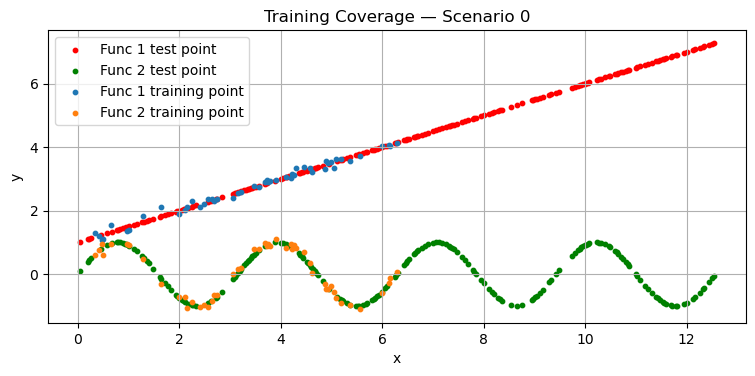

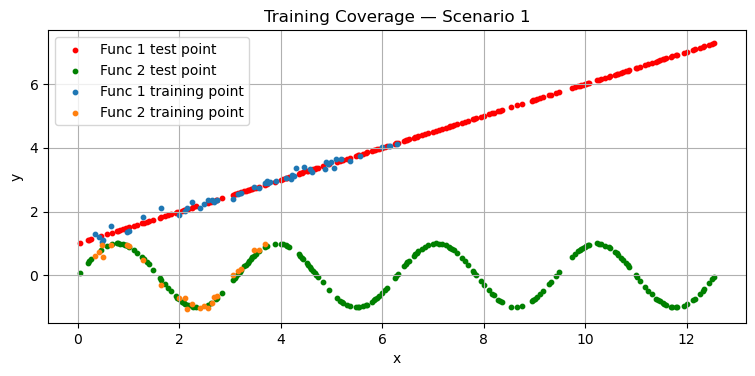

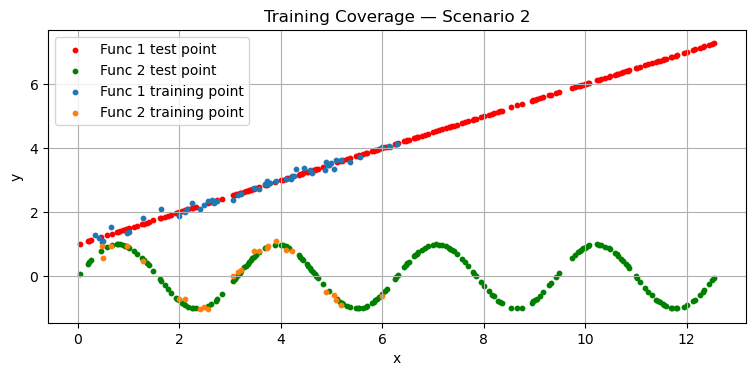

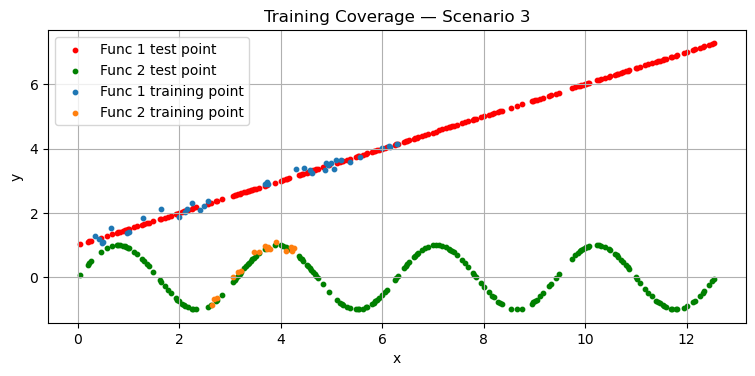

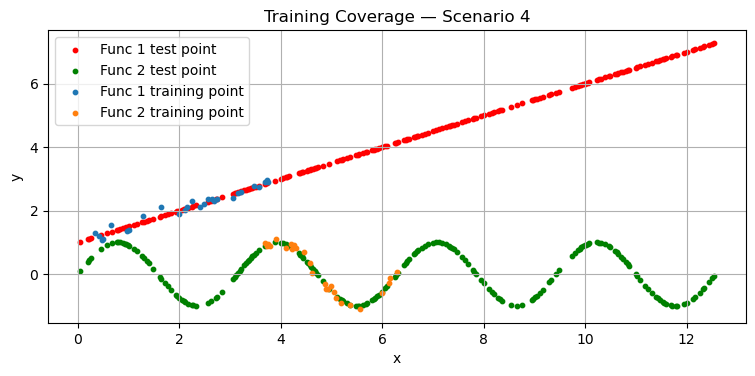

In [40]:
def plot_training_coverage(X_train, y1, y2, X_test, y1_test, y2_test, scenario_id):
    plt.figure(figsize=(9, 3.8))
    plt.scatter(X_test, y1_test, color="red", s=10, label="Func 1 test point")
    plt.scatter(X_test, y2_test, color="green", s=10, label="Func 2 test point")
    
    if np.any(~np.isnan(y1[:,0])):
        plt.scatter(X_train[~np.isnan(y1[:,0])], y1[~np.isnan(y1[:,0])],
                    s=10, label="Func 1 training point")
    if np.any(~np.isnan(y2[:,0])):
        plt.scatter(X_train[~np.isnan(y2[:,0])], y2[~np.isnan(y2[:,0])],
                    s=10, label="Func 2 training point")
    plt.title(f"Training Coverage — Scenario {scenario_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Try one scenario quickly
for sid in [0,1,2,3,4]:
    y1_s, y2_s, m1, m2 = apply_missing_scenario_fixed(X_train, y1_full, y2_full, sid)
    plot_training_coverage(X_train, y1_s, y2_s, X_test, y1_test, y2_test, sid)

In [50]:
from functools import reduce
import operator
import GPy
from sklearn.metrics import mean_squared_error

def build_slfm_model(X_train, y1, y2, kernel_types=["RBF", "Periodic"]):
    import GPy
    from functools import reduce
    import operator
    import numpy as np

    # === Prepare input ===
    X1 = X_train.copy()
    X2 = X_train.copy()
    y1 = y1.reshape(-1, 1)
    y2 = y2.reshape(-1, 1)
    
    X_input = np.vstack([X1, X2])
    Y_input = np.vstack([y1, y2])
    output_index = np.vstack([
        np.zeros_like(X1),  # output 0
        np.ones_like(X2)    # output 1
    ])
    X_full = np.hstack([X_input, output_index])  # (N*2, 2)

    # === Create latent kernels and coregionalize ===
    Q = len(kernel_types)
    coreg_kernels = []
    for q, kt in enumerate(kernel_types):
        if kt == "RBF":
            k = GPy.kern.RBF(input_dim=1, active_dims=[0], name=f"RBF_{q}")
            k.lengthscale = 1.0
            k.variance = 1.0
        elif kt == "Periodic":
            k = GPy.kern.PeriodicExponential(1, active_dims=[0], name=f"Per_{q}")
            k.lengthscale = 1.0
            k.variance = 1.0
            k.period = 2*np.pi
        else:
            raise ValueError("Unsupported kernel type")
        
        B = GPy.kern.Coregionalize(1, output_dim=2, rank=2)
        coreg_kernels.append(k.prod(B, name=f"ICM{q}"))

    kernel = reduce(operator.add, coreg_kernels)

    # === Build model ===
    model = GPy.models.GPRegression(X_full, Y_input, kernel)

    # === Add noise and constraints ===
    model.likelihood.variance[:] = 0.01
    model.likelihood.variance.constrain_bounded(1e-3, 0.5)

    # Optional: constrain kernel parameters
    for k in model.kern.parts:
        if hasattr(k, 'lengthscale'):
            k.lengthscale.constrain_bounded(0.1, 10)
        if hasattr(k, 'variance'):
            k.variance.constrain_bounded(0.1, 10)
        if hasattr(k, 'period'):
            k.period.constrain_bounded(2.5, 7.0)

    # === Optimize ===
    model.optimize(messages=True, max_iters=1000)

    return model

In [52]:
def get_missing_predictions(model, X_train, mask, output_idx):
    X_missing = X_train[~mask]
    if len(X_missing) == 0:
        return None, None, None
    X_input = np.hstack([X_missing, np.full_like(X_missing, output_idx)])
    mu, var = model.predict(X_input)
    return mu, var, X_missing

In [54]:
def run_slfm_scenario_fixed(sid, X_train, X_test, y1_full, y2_full, y1_test, y2_test):
    print(f"\n=== Scenario {sid} ===")
    y1, y2, m1, m2 = apply_missing_scenario_fixed(X_train, y1_full, y2_full, sid)
    model = build_slfm_model(X_train, y1, y2)

    # Test prediction
    outputs = [0, 1]
    plt.figure(figsize=(10, 4))
    for i, (test_y, label) in enumerate(zip([y1_test, y2_test], ['f1', 'f2'])):
        X_pred = np.hstack([X_test, np.full_like(X_test, i)])
        mu, var = model.predict(X_pred)
        std = np.sqrt(var)
        mse = mean_squared_error(test_y, mu)
        plt.subplot(1, 2, i+1)
        plt.plot(X_test, mu, label=f'Predicted {label}')
        plt.fill_between(X_test[:, 0], mu[:, 0]-2*std[:, 0], mu[:, 0]+2*std[:, 0], alpha=0.3)
        plt.plot(X_test, test_y, 'r--', label='True')
        plt.title(f'{label} — Test MSE: {mse:.4f}')
        plt.grid(True)
        plt.legend()
    plt.suptitle(f'Scenario {sid} — Test Prediction')
    plt.tight_layout()
    plt.show()

    # Missing point prediction
    for i, (y_full, mask, label) in enumerate(zip([y1_full, y2_full], [m1, m2], ['f1', 'f2'])):
        if np.all(mask):
            print(f"No missing points for {label}")
            continue
        mu, var, X_miss = get_missing_predictions(model, X_train, mask, i)
        mse_miss = mean_squared_error(y_full[~mask], mu)
        mean_std = np.mean(np.sqrt(var))
        print(f"{label} — MSE on missing: {mse_miss:.4f}, mean std: {mean_std:.4f}")
        plt.figure(figsize=(5, 3))
        plt.plot(X_miss, mu, label='Predicted')
        plt.fill_between(X_miss[:, 0], mu[:, 0]-2*np.sqrt(var[:, 0]), mu[:, 0]+2*np.sqrt(var[:, 0]), alpha=0.3)
        plt.plot(X_miss, y_full[~mask], 'r.', label='True')
        plt.title(f'{label} — Missing point prediction')
        plt.grid(True)
        plt.legend()
        plt.show()

In [56]:
for sid in range(5):
    run_slfm_scenario_fixed(sid, X_train, X_test, y1_full, y2_full, y1_test, y2_test)



=== Scenario 0 ===


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.